# Verify the Conv-VAE sensorprocessing

Load a pre-trained model specified by an experiment/run trained by Train-Conv-VAE

This notebook runs a number of visualizations that allow to illustrate the performance of the trained encoding. The verification here primarily happens through visual observation. 

In [1]:
import sys
sys.path.append("..")
# adding the Julian-8897-Conv-VAE-PyTorch into the path

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

sys.path.append(Config()["conv_vae"]["code_dir"])
# from encoding_conv_vae.conv_vae import latest_json_and_model

from sensorprocessing import sp_conv_vae
from sensorprocessing import sp_helper
from sensorprocessing.sp_helper import get_transform_to_sp, load_picturefile_to_tensor

from demonstration.demonstration import Demonstration

import matplotlib.pyplot as plt
# import pathlib
import random

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# At some point in the development, this hack was necessary for some reason. 
# It seems that as of Feb 2025, the code runs on Windows and Linux without it.
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml


Using device: cuda


In [2]:
# Specify the experiment
experiment = "sensorprocessing_conv_vae"
run = "proprio_128" 
exp = Config().get_experiment(experiment, run)
print(exp)
sp = sp_conv_vae.ConvVaeSensorProcessing(exp, device)

***ExpRun**: Configuration for exp/run: sensorprocessing_conv_vae/proprio_128 successfully loaded


Experiment:
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\sensorprocessing_conv_vae\proprio_128
    epochs: 5
    exp_run_sys_dep_file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\sensorprocessing_conv_vae\proprio_128_sysdep.yaml
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\sensorprocessing_conv_vae\proprio_128.yaml
    experiment_name: sensorprocessing_conv_vae
    image_size:
    - 64
    - 64
    json_template_name: conv-vae-config-default.json
    latent_size: 128
    model_checkpoint: checkpoint-epoch5.pth
    model_dir: models
    model_name: VAE_Robot
    model_subdir: 0517_195655
    run_name: proprio_128
    save_period: 5
    subrun_name: null
    time_started: '2025-05-24 18:28:16'
    training_data:
    - - freeform
      - '2024_12_26__16_40_20'
      - dev2
    - - freeform
      - '2024_12_26__16_44_06'
      - dev2
    training_

## Verify the Conv-VAE by visual reconstruction
We can verify a Conv-VAE model visually based on its ability to recover the input image from the encoding. The intuition here would be that information that is lost during the recovery is not present in the encoding, and thus it won't be usable by the algorithms using this encoding either.

In [11]:
# FIXME: the camera has to be specified etc.

# transform=sp_helper.get_transform_to_sp(exp)
# from demonstration.demonstration import get_simple_transform


transform = get_transform_to_sp(exp)
demos = []
cameras = []
# load the demonstrations specified in the experiment validation data
for val in exp["validation_data"]:
    run, demo_name, camera = val
    exp_demo = Config().get_experiment("demonstration", run)
    demo = Demonstration(exp_demo, demo_name)
    demos.append(demo)
    cameras.append(camera)

# Choose n pictures from the validation set
n = 6
demo = demos[0]
camera = cameras[0]
images = []
imagefiles = []
for i in range(demo.metadata["maxsteps"]):
    rnd = random.randint(0, demo.metadata["maxsteps"] - 1)
    imagefiles.append(demo.get_image_path(rnd))
    image, _ = demo.get_image(rnd, device=device, camera=camera, transform=transform)
    images.append(image)


***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_defaults_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded
***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_defaults_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded


In [12]:

for imagefile in imagefiles:
    print(imagefile)
    #z = sp.process_file(imagefile)
    #print(z)


    #sensor_readings, _ = load_picturefile_to_tensor(imagefile, self.transform)
    from torchvision import transforms

    #image_size = 64
    #transform = transforms.Compose([
    #    transforms.Resize(image_size),
    #    transforms.CenterCrop(image_size),
    #    transforms.ToTensor(),
    # ])

    transform = get_transform_to_sp(exp)
    sensor_readings, _ = load_picturefile_to_tensor(imagefile, transform, device)
    output = sp.process(sensor_readings)
    print(output)

    # image, _ = demo.get_image(rnd)
    # images.append(image)

c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\demonstration\freeform\2024_12_26__16_40_20\00075_dev2.jpg
[-0.16188796  0.6130224  -0.9263007  -0.7257262  -0.16336021 -0.69976264
 -0.96378565 -0.10267355  1.042448    0.19395855 -0.4938787   1.0150568
 -0.6004293  -0.16259971 -0.70324874 -0.8048152  -0.49905968 -0.35872647
  0.17868374  0.56700355  1.004033    0.19400379 -0.16261353  0.01715489
  0.4536101   1.0946506   0.13258122  0.8492099  -0.36273706  0.05116355
  0.392248    1.0787982   0.03202208  0.9340494   0.03795977 -1.0382774
 -1.0830833  -0.2331494  -0.48889118 -0.8981444   0.12501745  0.6312934
 -0.37665945  0.7001219  -0.0132547  -0.79696476  0.8231054  -0.39925963
  0.61253566 -0.5798788   0.9764705  -0.39363003  0.84656286 -0.06173351
 -0.1127127  -0.02042396 -0.3911702   0.67054135  0.912745    0.08456635
  1.0485371  -0.95135653  0.00892406  0.19674897  0.11243445  0.1047532
 -0.70657986  0.4055375   0.67845094 -0.73388445 -0.84936196  0.9536793
 -0.

In [13]:
# This cell simply verifies whether we can run the sensorprocessing on files
for image in images:
    z = sp.process(image)
    print(f"The encoding is\n {z}")

The encoding is
 [-0.16188796  0.6130224  -0.9263007  -0.7257262  -0.16336021 -0.69976264
 -0.96378565 -0.10267355  1.042448    0.19395855 -0.4938787   1.0150568
 -0.6004293  -0.16259971 -0.70324874 -0.8048152  -0.49905968 -0.35872647
  0.17868374  0.56700355  1.004033    0.19400379 -0.16261353  0.01715489
  0.4536101   1.0946506   0.13258122  0.8492099  -0.36273706  0.05116355
  0.392248    1.0787982   0.03202208  0.9340494   0.03795977 -1.0382774
 -1.0830833  -0.2331494  -0.48889118 -0.8981444   0.12501745  0.6312934
 -0.37665945  0.7001219  -0.0132547  -0.79696476  0.8231054  -0.39925963
  0.61253566 -0.5798788   0.9764705  -0.39363003  0.84656286 -0.06173351
 -0.1127127  -0.02042396 -0.3911702   0.67054135  0.912745    0.08456635
  1.0485371  -0.95135653  0.00892406  0.19674897  0.11243445  0.1047532
 -0.70657986  0.4055375   0.67845094 -0.73388445 -0.84936196  0.9536793
 -0.24512048 -0.7556141   0.34463698  0.92585355 -0.37747008  0.8293074
  0.34505877 -0.6303722   0.99211466 -0.

# Visualize the VAE reconstruction

In [ ]:
def visualize_VAE(sp, exp, picture_name, axoriginal, axreconstr):
    """Helper function to show the original and the reconstruction in fields of a picture."""
    transform = sp_helper.get_transform_to_sp(exp)
    input, image = sp_helper.load_picturefile_to_tensor(picture_name, transform)
    # Running the input on the output
    output, mu, logvar = sp.model(input)
    # Output: the visual reconstruction
    output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()
    # Showing the input and the reconstruction    
    axoriginal.imshow(image)
    axoriginal.set_title("Original")
    axreconstr.imshow(output_for_pic)
    axreconstr.set_title("Reconstruct")
    return output, mu, logvar

NameError: name 'randomjpg' is not defined

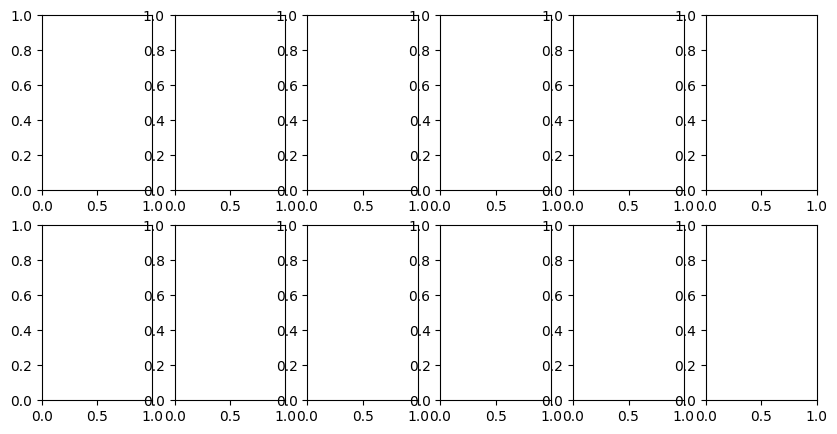

In [ ]:
# This cell visualizes the original and reconstructed pictures by going inside 
# the sensorprocessing object and accessing the model
fig, axs = plt.subplots(2, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, exp, randomjpg[i], axs[0,i], axs[1,i])
    print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")

## Reconstruction from noisy latent encoding


In [ ]:
# Visualize the original and reconstructed pictures 
fig, axs = plt.subplots(3, n, figsize=(10, 5))
for i in range(n):
    output, mu, logvar = visualize_VAE(sp, randomjpg[i], axs[0,i], axs[1,i])
    # print(f"Pictures{i}\nmu={mu}\nlogvar={logvar}")
    # this samples a new z with its logvar
    z2 = sp.model.reparameterize(mu, logvar)
    # adding some noise to the encoding (FIXME: add random noise)
    for j in range(exp["latent_size"]):
        z2[0][j] = z2[0][j] + 0.001
    #output2 = sp.model.decode(z2)
    output2 = sp.model.decode(mu)
    output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
    axs[2,i].imshow(output_for_pic2)
    axs[2,i].set_title("Noised")


# Generating random samples from the model

In [ ]:

# this can be actually done by just calling sp.model.sample!
samples = sp.model.sample(num_samples = 25, current_device=device)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
i = 0
for x in range(0, 5):
    for y in range(0, 5):
        output_for_pic = samples[i].cpu().permute(1, 2, 0).detach().numpy()
        axs[x][y].imshow(output_for_pic)
        i += 1
